### Tidal influence on 2km HFR data availability outside of SF Bay ###

The number of surface current totals outside of the Golden Gate Bridge seems to be correlated with tides, or at least affected by some semi-diurnal (or diurnal) process.

Here, I'm analyzing the 2km HFR data from hfr-net and tidal data from the NOAA CO-OPs station at Crissy Field. As these are not co-located, there may be some temporal lag between theses areas, but it is presumed to be minimal and consistent.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import numpy as np
from scipy import signal
import pandas as pd
import requests
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context('talk')

In [2]:
def make_map():
    """Map helped function """
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
#     ax.set_xlim(-123.75,-122)
#     ax.set_ylim(37.2,38.25)
    return(fig, ax)

__Retrieving the data from hfrnet THREDDS server__

To reduce the size of data egress, only data since 2020-Jan-01 are requested and the data are spatially subsetted to the region of interest.

In [3]:
extent=[-123.2, -122.45, 37.3, 38.1] #Golden Gate
# extent=[-122.2, -121.77, 36.57, 37.1] #MBAY
# extent=[-121.75, -120.5,  34.8, 35.4] #Morro

ds = xr.open_dataset("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd")
ds = ds.sel(lat=slice(extent[2],extent[3]), lon=slice(extent[0],extent[1]))
ds = ds.sel(time = slice(dt.datetime(2020,1,1), dt.datetime.today()))

__Quantifying Valid measurments__

For each time step, at each grid a boolean is assigned if values are finite. Where no valid measurement exists, ie the value is a NaN, a False is assigned (shown in Purple below) and where a valid measuremente exists, the True is assigned, shown in Yellow.

For each timestep the number of True values is summed up to create an hourly timeseries of the number of valid measurments in the box

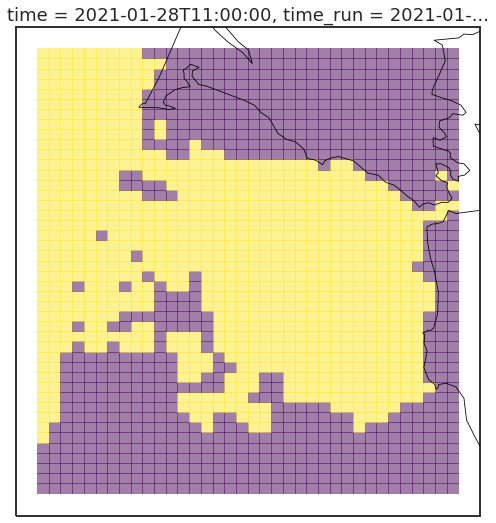

In [4]:
fig, ax = make_map()
vals = ds['u'].isel(time=-1)
finite_values = np.isfinite(vals)
im = finite_values.plot(add_colorbar=False,alpha = .50)

Text(0, 0.5, '# [measurements]')

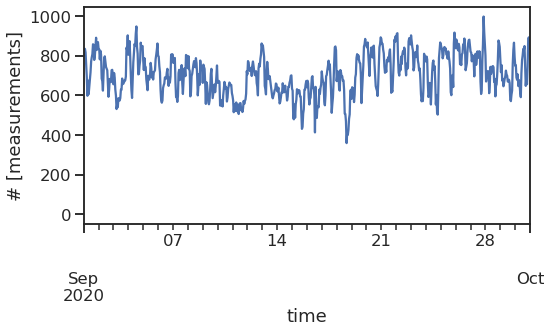

In [5]:
finite_values = np.isfinite(ds['u'])
df = finite_values.sum(dim={'lat','lon'}).to_pandas()
df = pd.DataFrame(df,columns=['num_solutions'])
##PLot the data
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
df['num_solutions'].plot(ax=ax)
ax.set_xlim('20200901','20201001')
ax.set_ylabel('# [measurements]')

In [8]:
len(finite_values.time)

9444

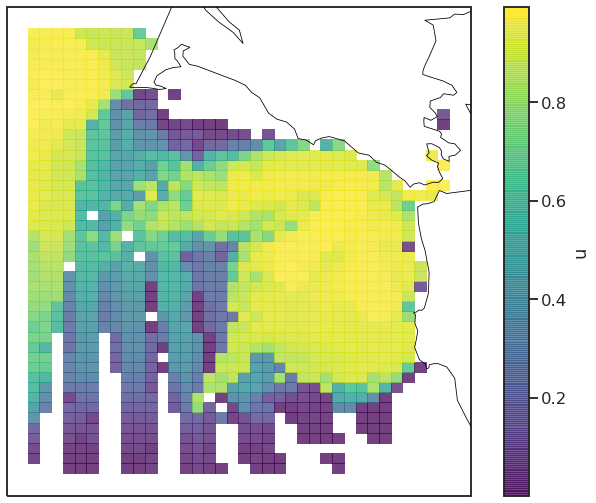

In [9]:
spatial_var = finite_values.sum(dim={'time'})/len(finite_values.time)


spatial_var = spatial_var.where(spatial_var != 0) 
fig,ax = make_map()
spatial_var.plot(ax=ax,alpha=.75)

In [100]:
oct_vals = finite_values.sel(time=slice('20201012','20201016'))
print(oct_vals.shape)
oct_num = df.query("time >= '20201012' & time < '20201017' ")
print(oct_num.shape)

(120, 44, 36)
(120, 1)


In [103]:
for i in range(oct_num.shape[0]):

    fig = plt.figure(constrained_layout=False,figsize=(8, 10))
    gs = fig.add_gridspec(nrows=3, ncols=1)
    ax1 = fig.add_subplot(gs[:2, 0],projection=ccrs.PlateCarree())
    ax1.coastlines('10m', linewidth=0.8,zorder=200)
    oct_vals.isel(time=i).plot(ax=ax1, alpha=.5, add_colorbar=False)
    t = oct_vals.isel(time=i)['time'].values

    ax2 = fig.add_subplot(gs[2, 0])
    oct_num.plot(ax=ax2)
    temp = oct_num.query("time ==  @t")
    ax2.scatter(temp.index.values, temp.values, c='r')
    plt.savefig(f"Figures/data_availability/sfBay_density_frame_{i:04}.png")
    plt.close()


In [104]:
import glob
from PIL import Image

In [105]:
# filepaths
fp_in = "Figures/data_availability/sfBay_density_frame_*.png"
fp_out = "Figures/data_availability/density_animation.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

__Filtering data__

To understand if there is a tidal signal a low-pass filter was used to remove the tidal signal and then subract the low-pass data from the original signal, the result is the tidal signal


In [21]:
def lanc(numwt, haf):
    """
    Generates a numwt + 1 + numwt lanczos cosine low pass filter with -6dB
    (1/4 power, 1/2 amplitude) point at half
    Parameters
    ----------
    numwt : int
            number of points
    haf : float
          frequency (in 'cpi' of -6dB point, 'cpi' is cycles per interval.
          For hourly data cpi is cph,
    
    From the python-oceans python package
    https://github.com/pyoceans/python-oceans/blob/master/oceans/filters.py
    """
    summ = 0
    numwt += 1
    wt = np.zeros(numwt)

    # Filter weights.
    ii = np.arange(numwt)
    wt = 0.5 * (1.0 + np.cos(np.pi * ii * 1.0 / numwt))
    ii = np.arange(1, numwt)
    xx = np.pi * 2 * haf * ii
    wt[1 : numwt + 1] = wt[1 : numwt + 1] * np.sin(xx) / xx
    summ = wt[1 : numwt + 1].sum()
    xx = wt.sum() + summ
    wt /= xx
    return np.r_[wt[::-1], wt[1 : numwt + 1]]



In [22]:
freq = 1./40  # 40 Hours
window_size = 48+1+48
pad = np.zeros(window_size) * np.NaN

wt = lanc(window_size, freq)
res = np.convolve(wt, df['num_solutions'], mode='same')
res[-48:] = np.nan
res[:48] = np.nan

df['low'] = res
df['high'] = df['num_solutions'] - df['low']

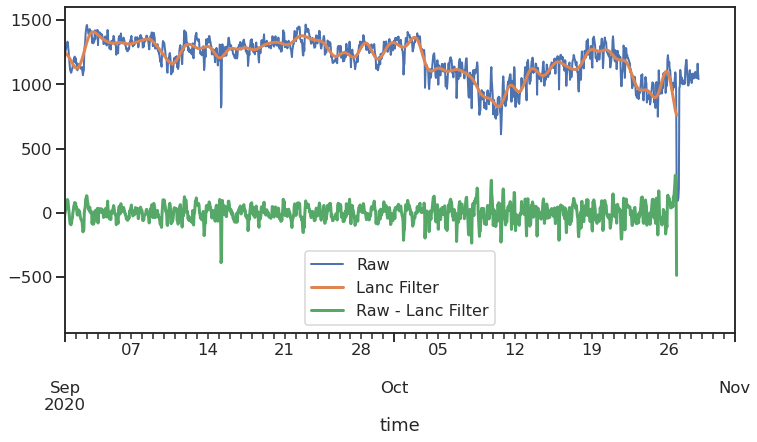

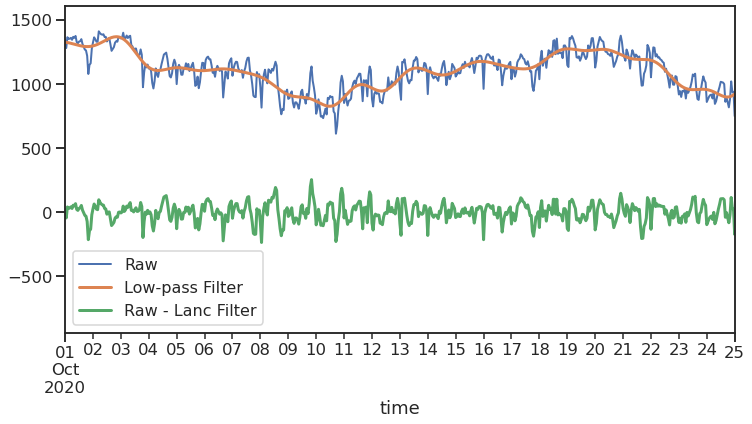

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
df['num_solutions'].plot(ax=ax,lw=2,label='Raw')
df['low'].plot(ax=ax,lw=3,label='Lanc Filter')
df['high'].plot(ax=ax,lw=3,label='Raw - Lanc Filter')
ax.set_xlim('20200901','20201101')
plt.legend(fontsize=16)
# Zoomed in
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
df['num_solutions'].plot(ax=ax,lw=2,label='Raw')
df['low'].plot(ax=ax,lw=3,label='Low-pass Filter')
df['high'].plot(ax=ax,lw=3,label='Raw - Lanc Filter')
ax.set_xlim('20201001','20201025')
plt.legend(fontsize=16)

__Power Density Spectrum__

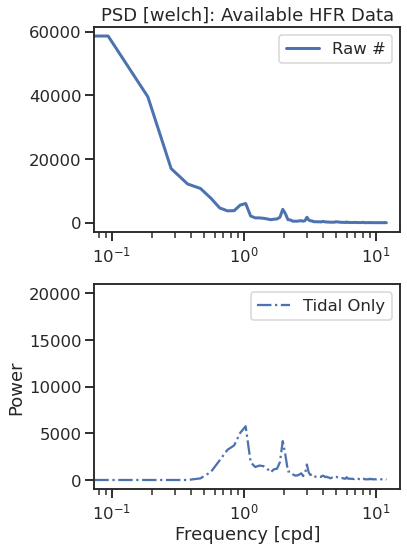

In [24]:
fig, (ax, ax2) = plt.subplots(2)
fig.set_size_inches(6,8)
ax.set_title('PSD [welch]: Available HFR Data')

freqs, psd = signal.welch(df['num_solutions'],fs=24)
ax.semilogx(freqs, psd,label='Raw #', lw=3)
plt.xlabel('Frequency [cpd]')
plt.ylabel('Power')
ax.legend()

freqs, psd = signal.welch(df['high'].dropna(),fs=24)
ax2.semilogx(freqs, psd,label='Tidal Only', ls='-.')
ax2.set_ylim(-1000,21000)
plt.xlabel('Frequency [cpd]')
plt.ylabel('Power')
plt.legend()

plt.tight_layout()

## Get Tide Data ##

Tidal height data is accessed through the NOAA Tides and Currents API

In [25]:
noaa_api_request = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20200901&end_date=20201028&station=9414290&product=hourly_height&datum=MLLW&time_zone=gmt&units=english&format=json"
r = requests.get(noaa_api_request)
if r.ok:
    tides = pd.DataFrame(r.json()['data'])
    tides['date'] = pd.to_datetime(tides["t"])
    tides.index = tides['date']
    tides['v'] = tides['v'].astype(float)

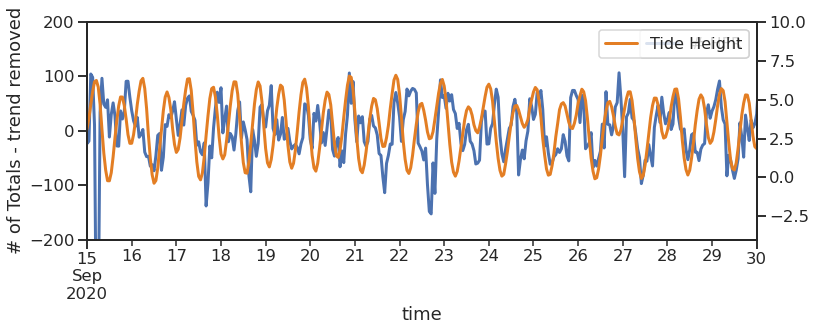

In [27]:
fig, (ax) = plt.subplots(sharex=True)
fig.set_size_inches(12,4)

df['high'].plot(ax=ax,lw=3,label='# HFR')
ax.set_ylabel('# of Totals - trend removed')
plt.legend(fontsize=16)

ax.set_ylim(-200,200)
ax2 = plt.twinx(ax)

tides['v'].plot(ax=ax2,lw=3,color='#E37E24',label="Tide Height")
ax2.set_ylim(-4,10)
ax2.set_xlim('20200915','20200930')

plt.legend(fontsize=16)

__Calculate Auto-correlation for upto a 48 hour lag__

Text(0, 0.5, 'Correlation')

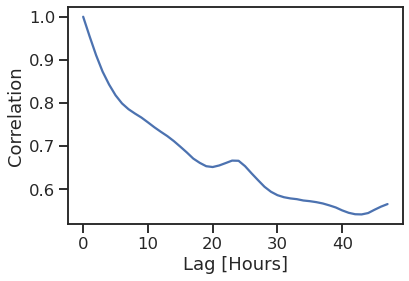

In [28]:
hours = np.arange(0,48)
corr = []
for hr in hours:
    corr.append(df['num_solutions'].autocorr(hr))
fig,ax = plt.subplots()
ax.plot(hours, corr)

ax.set_xlabel('Lag [Hours]')
ax.set_ylabel('Correlation')


In [155]:
tides

,t,v,s,f,date
date,,,,,
2020-09-01 00:00:00,2020-09-01 00:00,2.619,0.052,"0,0",2020-09-01 00:00:00
2020-09-01 01:00:00,2020-09-01 01:00,2.872,0.059,"0,0",2020-09-01 01:00:00
2020-09-01 02:00:00,2020-09-01 02:00,3.597,0.059,"0,0",2020-09-01 02:00:00
2020-09-01 03:00:00,2020-09-01 03:00,4.493,0.069,"0,0",2020-09-01 03:00:00
2020-09-01 04:00:00,2020-09-01 04:00,5.441,0.052,"0,0",2020-09-01 04:00:00
...,...,...,...,...,...
2020-09-30 19:00:00,2020-09-30 19:00,5.329,0.128,"0,0",2020-09-30 19:00:00
2020-09-30 20:00:00,2020-09-30 20:00,4.972,0.125,"0,0",2020-09-30 20:00:00
2020-09-30 21:00:00,2020-09-30 21:00,4.158,0.121,"0,0",2020-09-30 21:00:00


In [4]:
import xarray as xr

In [5]:
ds = xr.open_dataset("http://thredds.cencoos.org/thredds/dodsC/COAMPS_4KM_10M_WIND.nc")